# Starbucks Capstone Challenge

## Table of Contents:
1. Introduction
    * Example
    * Cleaning
    * Final Advice
2. Data Sets
    * Importing Libraries
    * Loading the dataset
3. Data Exploration
    * Offer portfolio data
    * Demographic data
    * Transactional records
4. Data Cleaning: 
 - Dropping duplicates.
 - Cleaning missing rows.
4. **Data Visualization:** Using plots to find relations between the features.
    - Get Correlation between different variables
    - Plot all Neighbourhood Group
    - Neighbourhood
    - Room Type
    - Relation between neighbourgroup and Availability of Room
    - Map of Neighbourhood group
    - Map of Neighbourhood
    - Availabity of rooom
5. **Regression Analysis**
 - Linear Regression
 - Evaluated metrics

## 1. Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### a. Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### b. Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### c. Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## 2. Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [66]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import json
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### a. Offer portfolio data
`portfolio.json `- containing offer ids and meta data about each offer (duration, type, etc.)

In [22]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


`channels` has categorical data.
`difficulty`is in terms of dollars.
`duration` is in terms of days
So, feature scaling will need to be done.

In [23]:
#check for null values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In portfolio dataset there are no missing values.

In [28]:
#check no. of unique offers
portfolio.id.nunique()

10

In [25]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 10 unique offer ids we will have to take note of, with 4 each of bogo and discount types, while 2 informational types.

### b. Demographic data

In [26]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


From the first 5 lines we can already see some null values in `gender` and `income`, while the `age` column contains some values that don't make sense (e.g. 118).

Compute customer gender attribute distribution

In [35]:
#Compute customer gender attribute distribution
gender_counts = profile['gender'].value_counts()
gender_counts *= 100 / gender_counts.sum()
gender_counts

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

In [27]:
#check for null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

The `gender` and `income` have null values.

In [29]:
#check count of age=118 value and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


As we can see above, the `age=118` column corresponds with the null `gender` and `income` columns. Thus, we can actually drop them during preprocessing if they do not take too large a proportion of our data.

In [30]:
#check how many unique people are in dataset
profile['id'].nunique()

17000

**Compute summary customer profile attribute statistics when customer income is not specified**

In [38]:
#print summary customer profile attribute statistics
profile[profile['income'].isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


### c. Transactional records

In [31]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [32]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [33]:
#check number of unique people represented
transcript['person'].nunique()

17000

It looks as though the number of people in transcript are the same as the number of people in the Demographics Data

In [34]:
#check for null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

There are no null values in this data.

## 3. Data Cleaning

### 3.1 portfolio Data
- Changed the name of the 'id' column to 'offerid'
- Removed underscores from column names
- One hot encode the 'offertype' column and 'channels' columns

In [50]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [51]:
from datetime import datetime
def update_column_name(dataframe,
                       old_column_name,
                       new_column_name):
    """ Updates a Pandas DataFrame column name
    INPUT:
        dataframe: Pandas DataFrame object
        old_column_name: String that stores the old column name
        new_column_name: String that stores the new column name
    OUTPUT:
        column_names: np.array that stores the updated Pandas DataFrame
                      column names"""
    column_names = dataframe.columns.values
    
    select_data = np.array([elem == old_column_name for elem in column_names])

    column_names[select_data] = new_column_name
        
    return column_names
def convert_to_datetime(elem):
    """Converts a string to a datetime object
    
    INPUT:
        elem: String that stores a date in the %Y%m%d format
    OUTPUT:
        datetimeobj: Datetime object"""
    return datetime.strptime(str(elem), '%Y%m%d')

In [52]:
def clean_portfolio(data_dir="./data"):
    """ 
    Transforms a DataFrame containing offer ids and meta data about 
    each offer (duration, type, etc.)
    INPUT:
        (Optional) data_dir: String that stores the full path to the
                             data directory
    OUTPUT:
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
    """
    portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
    
    # Change the name of the 'id' column to 'offerid'
    columns = update_column_name(portfolio,'id','offerid')
    


    # Remove underscores from column names
    portfolio.columns = [re.sub('_', '', elem) for elem in columns]

    # Initialize a list that stores the desired output DataFrame 
    # column ordering
    

    # Return the "cleaned" portfolio data
    return portfolio
portfolio = clean_portfolio()
portfolio

,reward,channels,difficulty,duration,offertype,offerid
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [53]:
#offertype has categorical data
portfolio['offertype']

0             bogo
1             bogo
2    informational
3             bogo
4         discount
5         discount
6         discount
7    informational
8             bogo
9         discount
Name: offertype, dtype: object

In [54]:
column_ordering = ['offerid',
                   'difficulty',
                   'durationdays',
                   'reward']

    # One hot encode the 'offertype' column
offertype_df = pd.get_dummies(portfolio['offertype'])

column_ordering.extend(offertype_df.columns.values)

    # One hot encode the 'channels' columns
ml_binarizerobj = MultiLabelBinarizer()
ml_binarizerobj.fit(portfolio['channels'])

channels_df =\
    pd.DataFrame(ml_binarizerobj.transform(portfolio['channels']),
    columns=ml_binarizerobj.classes_)

column_ordering.extend(channels_df.columns.values)

    # Replace the 'offertype' and 'channels' columns
portfolio = pd.concat([portfolio, offertype_df, channels_df], axis=1)

portfolio = portfolio.drop(columns=['offertype', 'channels'])

### 3.2 profile
- Removed customers with missing income data and customer profiles where the gender attribute is missing
- Changed the name of the 'id' column to 'customerid'
- Transformed the 'became_member_on' column to a datetime object and gender column from a character to a number.
- One hot encode a customer's membership start year, start Month and age range


In [55]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [56]:
def clean_profile(data_dir = "./data"):
    """ Transforms a DataFrame that contains demographic data for each 
    customer
    
    INPUT:
        (Optional) data_dir: String that stores the full path to the
                             data directory
    
    OUTPUT:
        profile: DataFrame that contains demographic data for each 
                 customer
    """
    profile = pd.read_json('data/profile.json',
                           orient='records',
                           lines=True)
    profile_remove = profile[profile.age == 118]

    # Remove customers with N/A income data
    profile = profile[profile['income'].notnull()]

    # Remove customers with unspecified gender
    profile = profile[profile['gender'] != 'O']
    profile = profile.reset_index(drop=True)

    # Change the name of the 'id' column to 'customerid'
    profile.columns = update_column_name(profile,
                                         'id',
                                         'customerid')

    # Initialize a list that describes the desired DataFrame column
    # ordering
    column_ordering = ['customerid',
                       'gender',
                       'income']

    # Transform the 'became_member_on' column to a datetime object
    profile['became_member_on']= profile['became_member_on'].apply(convert_to_datetime)

    # One hot encode a customer's membership start year
    profile['membershipstartyear'] =\
        profile['became_member_on'].apply(lambda elem: elem.year)
    
    # One hot encode a customer's membership start month
    profile['membershipstartMonth'] =\
        profile['became_member_on'].apply(lambda elem: elem.month)

     

    # Transform a customer's gender from a character to a number
    recode = {'M': 0, 'F': 1}
    profile.replace({'gender': recode}, inplace=True)
    
    min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
    max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

    profile['agerange'] =\
        pd.cut(profile['age'],
               (range(min_age_limit,max_age_limit + 10, 10)),
               right=False)
    profile['agerange'] = profile['agerange'].astype('str')

    # Return a DataFrame with "clean" customer profile data
    return profile

In [57]:
profile = clean_profile()

In [58]:
profile.head()

,gender,age,customerid,became_member_on,income,membershipstartyear,membershipstartMonth,agerange
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)"
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,"[70, 80)"
2,0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,"[60, 70)"
3,0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,"[60, 70)"
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,"[50, 60)"


In [59]:
column_ordering = []
agerange_df = pd.get_dummies(profile['agerange'])
column_ordering.extend(agerange_df.columns.values)
profile = pd.concat([profile,agerange_df], axis=1)
profile.head()

,gender,age,customerid,became_member_on,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,0,0,0,1,0,0,0,0
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,"[70, 80)",0,0,0,0,0,0,0,1,0,0
2,0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,"[60, 70)",0,0,0,0,0,0,1,0,0,0
3,0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,"[60, 70)",0,0,0,0,0,0,1,0,0,0
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,"[50, 60)",0,0,0,0,0,1,0,0,0,0


### 3.3 Transcript Data
- The name of the 'person' column change into 'customerid'and 'time' column to 'timedays',removed customer id's that are not in the customer profile DataFrame. also,converted time variable from hours to days
- Create a two DataFrame that describes: offers and customer transaction events.
- One hot encode offer events

In [60]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [62]:
def clean_transcript(profile,
                     data_dir = './data'):
    """ Transforms a DataFrame that contains records for transactions, offers
    received, offers viewed, and offers completed
    INPUT:
        profile: DataFrame that contains demographic data for each 
                 customer
        (Optional) data_dir: String that stores the full path to the
                             data directory
    OUTPUT:
        offer_data: DataFrame that describes customer offer data
        transaction: DataFrame that describes customer transactions
    """
    transcript = pd.read_json(os.path.join(data_dir,
                                           'transcript.json'),
                              orient='records',
                              lines=True)

    # Change the name of the 'person' column to 'customerid'
    transcript.columns = update_column_name(transcript,
                                            'person',
                                            'customerid')

    # Remove customer id's that are not in the customer profile DataFrame
    select_data = transcript['customerid'].isin(profile['customerid'])
    transcript = transcript[select_data]

    percent_removed = 100 * (1 - select_data.sum() / select_data.shape[0])
    print("Percentage of transactions removed: %.2f %%" % percent_removed)

    # Convert from hours to days
    transcript['time'] /= 24.0
    
    # Change the name of the 'time' column to 'timedays'
    transcript.columns = update_column_name(transcript,
                                            'time',
                                            'timedays')

    # Select customer offers
    pattern_obj = re.compile('^offer (?:received|viewed|completed)')

    h_is_offer = lambda elem: pattern_obj.match(elem) != None

    is_offer = transcript['event'].apply(h_is_offer)

    offer_data = transcript[is_offer].copy()
    offer_data = offer_data.reset_index(drop=True)

    # Initialize a list that describes the desired output DataFrame
    # column ordering
    column_order = ['offerid', 'customerid', 'timedays']

    # Create an offerid column
    offer_data['offerid'] =\
        offer_data['value'].apply(lambda elem: list(elem.values())[0])

    # Transform a column that describes a customer offer event
    pattern_obj = re.compile('^offer ([a-z]+$)')

    h_transform = lambda elem: pattern_obj.match(elem).groups(1)[0]

    offer_data['event'] = offer_data['event'].apply(h_transform)

    # One hot encode customer offer events
    event_df = pd.get_dummies(offer_data['event'])
    column_order.extend(event_df.columns.values)

    # Create a DataFrame that describes customer offer events
    offer_data = pd.concat([offer_data, event_df], axis=1)
    offer_data.drop(columns=['event', 'value'])
    offer_data = offer_data[column_order]

    # Select customer transaction events
    transaction = transcript[is_offer == False]
    transaction = transaction.reset_index(drop=True)

    # Transform customer transaction event values
    transaction['amount'] =\
        transaction['value'].apply(lambda elem: list(elem.values())[0])

    # Create a DataFrame that describes customer transactions
    transaction = transaction.drop(columns=['event','timedays'])
    column_order = ['customerid', 'amount']
    transaction = transaction[column_order]

    return offer_data, transaction

In [63]:
offer_data, transaction = clean_transcript(profile)
transaction.head()

Percentage of transactions removed: 12.31 %


,customerid,amount
0,02c083884c7d45b39cc68e1314fec56c,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,34.56
2,54890f68699049c2a04d415abc25e717,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,18.97


In [64]:
offer_data.head()

,offerid,customerid,timedays,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


## 4.Data Exploration

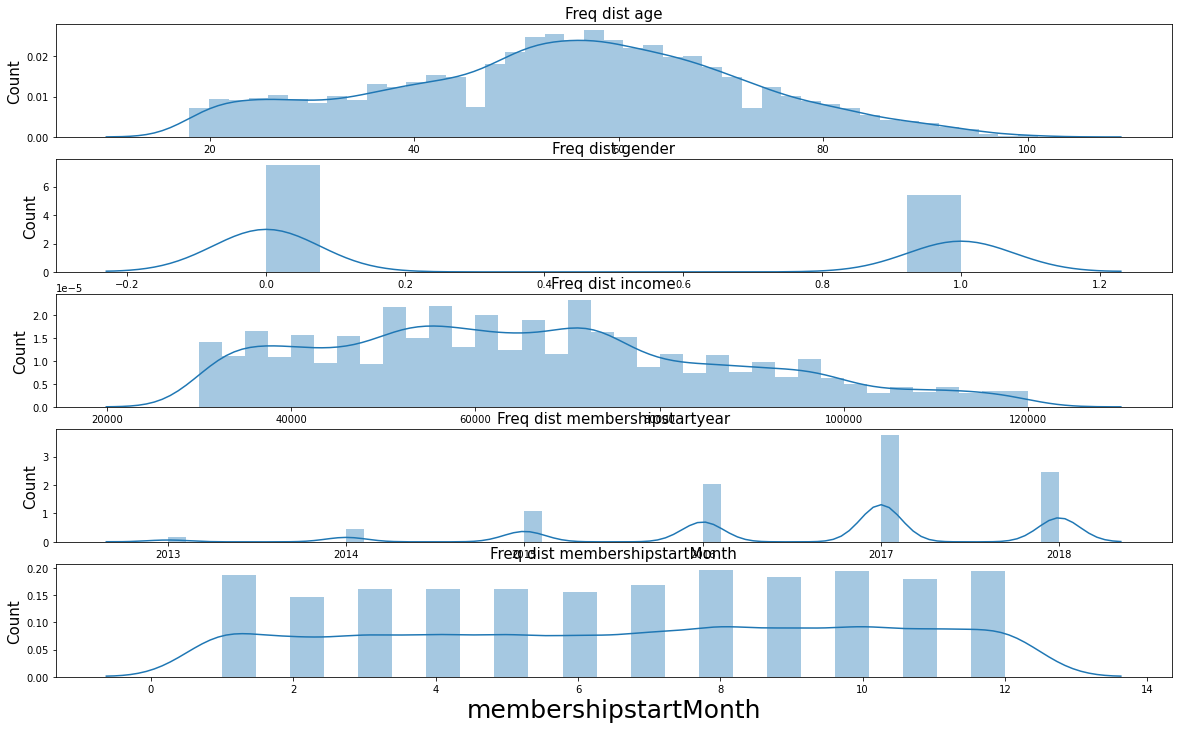

In [72]:
col_names = ['age', 'gender', 'income', 'membershipstartyear','membershipstartMonth']

fig, ax = plt.subplots(len(col_names), figsize=(20,12))

for i, col_val in enumerate(col_names):
    sns.distplot(profile[col_val], hist=True, ax=ax[i]) 
    ax[i].set_title("Freq dist " + col_val, fontsize=15)
    ax[i].set_xlabel(col_val, fontsize=25)
    ax[i].set_ylabel('Count', fontsize=15)
plt.show()

### 1. Explorer Income by gender for each Month

In [77]:
#Select Female from profile dataset
profileforFemale = profile.copy()
profileforFemale = profileforFemale[profileforFemale['gender'] == 1]
profileforFemale.head()

,gender,age,customerid,became_member_on,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,0,0,0,1,0,0,0,0
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,"[70, 80)",0,0,0,0,0,0,0,1,0,0
5,1,61,aa4862eba776480b8bb9c68455b8c2e1,2017-09-11,57000.0,2017,9,"[60, 70)",0,0,0,0,0,0,1,0,0,0
7,1,62,31dda685af34476cad5bc968bdb01c53,2016-02-11,71000.0,2016,2,"[60, 70)",0,0,0,0,0,0,1,0,0,0
10,1,61,a448667f336b42c9a66fc5ffd5d73772,2018-05-01,40000.0,2018,5,"[60, 70)",0,0,0,0,0,0,1,0,0,0


In [78]:
#select income for female members
datamembershipstartMonthF = profileforFemale.groupby('membershipstartMonth')['income'].sum().reset_index()
datamembershipstartMonthF.reset_index(drop=True)
datamembershipstartMonthF.head(12)

,membershipstartMonth,income
0,1,36809000.0
1,2,27369000.0
2,3,34506000.0
3,4,32908000.0
4,5,32377000.0
5,6,31747000.0
6,7,36168000.0
7,8,41128000.0
8,9,38705000.0
9,10,41857000.0


In [81]:
#Select Male from profile dataset
profileforMale = profile.copy()
profileforMale = profileforMale[profileforMale['gender'] == 0]
profileforMale.head()

,gender,age,customerid,became_member_on,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
2,0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,"[60, 70)",0,0,0,0,0,0,1,0,0,0
3,0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2,"[60, 70)",0,0,0,0,0,0,1,0,0,0
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11,"[50, 60)",0,0,0,0,0,1,0,0,0,0
6,0,26,e12aeaf2d47d42479ea1c4ac3d8286c6,2014-02-13,46000.0,2014,2,"[20, 30)",0,0,1,0,0,0,0,0,0,0
8,0,49,62cf5e10845442329191fc246e7bcea3,2014-11-13,52000.0,2014,11,"[40, 50)",0,0,0,0,1,0,0,0,0,0


In [80]:
#select income for Male members
datamembershipstartMonthM = profileforMale.groupby('membershipstartMonth')['income'].sum().reset_index()
datamembershipstartMonthM.reset_index(drop=True)
datamembershipstartMonthM.head(12)

,membershipstartMonth,income
0,1,47689000.0
1,2,38517000.0
2,3,38677000.0
3,4,40552000.0
4,5,42459000.0
5,6,40005000.0
6,7,40591000.0
7,8,50304000.0
8,9,45555000.0
9,10,47512000.0


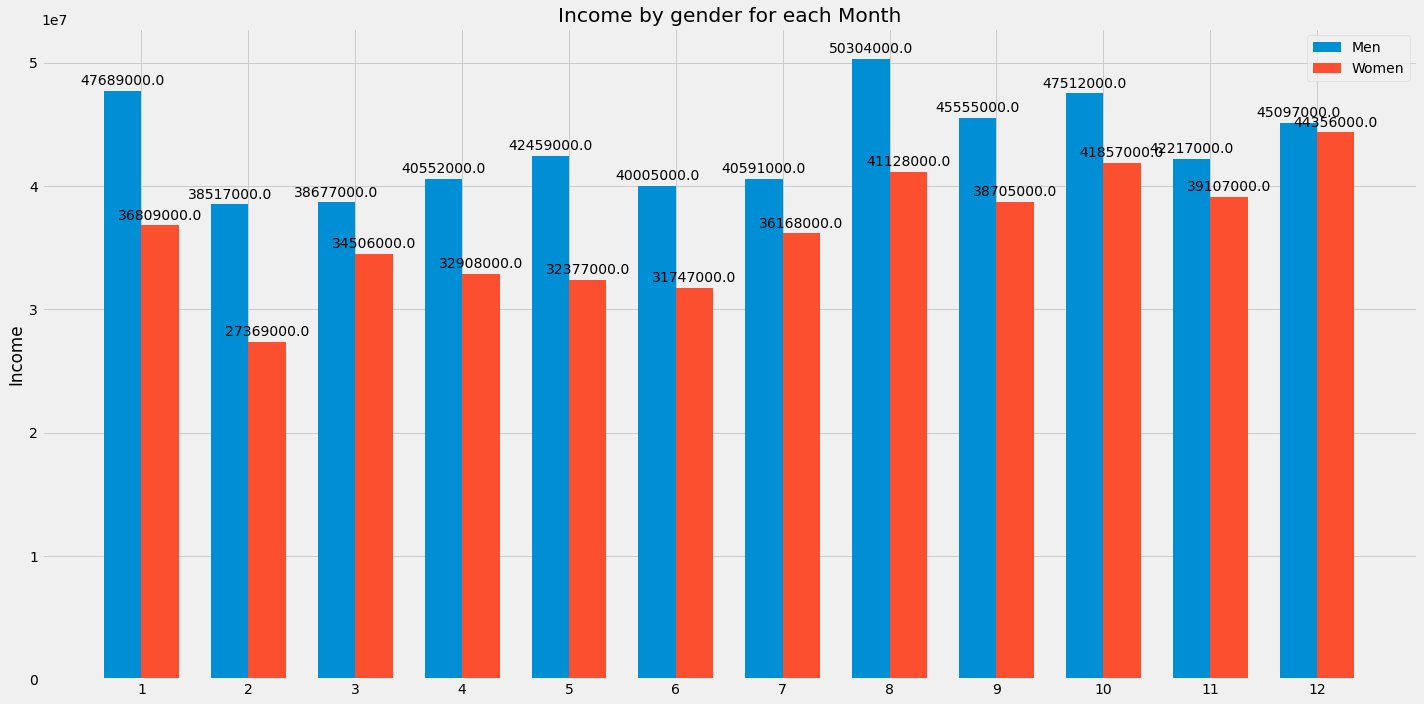

In [82]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
labels = datamembershipstartMonthM.membershipstartMonth
men = datamembershipstartMonthM.income
women = datamembershipstartMonthF.income

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, men, width, label='Men')
rects2 = ax.bar(x + width/2, women, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Income')
ax.set_title('Income by gender for each Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

The above graph is about the income by gender for each month. As shown in the graph mens has more income than women. 

### 2. Income by gender for each Year

datamembershipstartyearF = profileforFemale.groupby('membershipstartyear')['income'].sum().reset_index()
datamembershipstartyearF.reset_index(drop=True)
datamembershipstartyearF.head(12)

In [87]:
datamembershipstartyearM = profileforMale.groupby('membershipstartyear')['income'].sum().reset_index()
datamembershipstartyearM.reset_index(drop=True)
datamembershipstartyearM.head(12)

,membershipstartyear,income
0,2013,11030000.0
1,2014,29828000.0
2,2015,57476000.0
3,2016,98242000.0
4,2017,187731000.0
5,2018,134868000.0


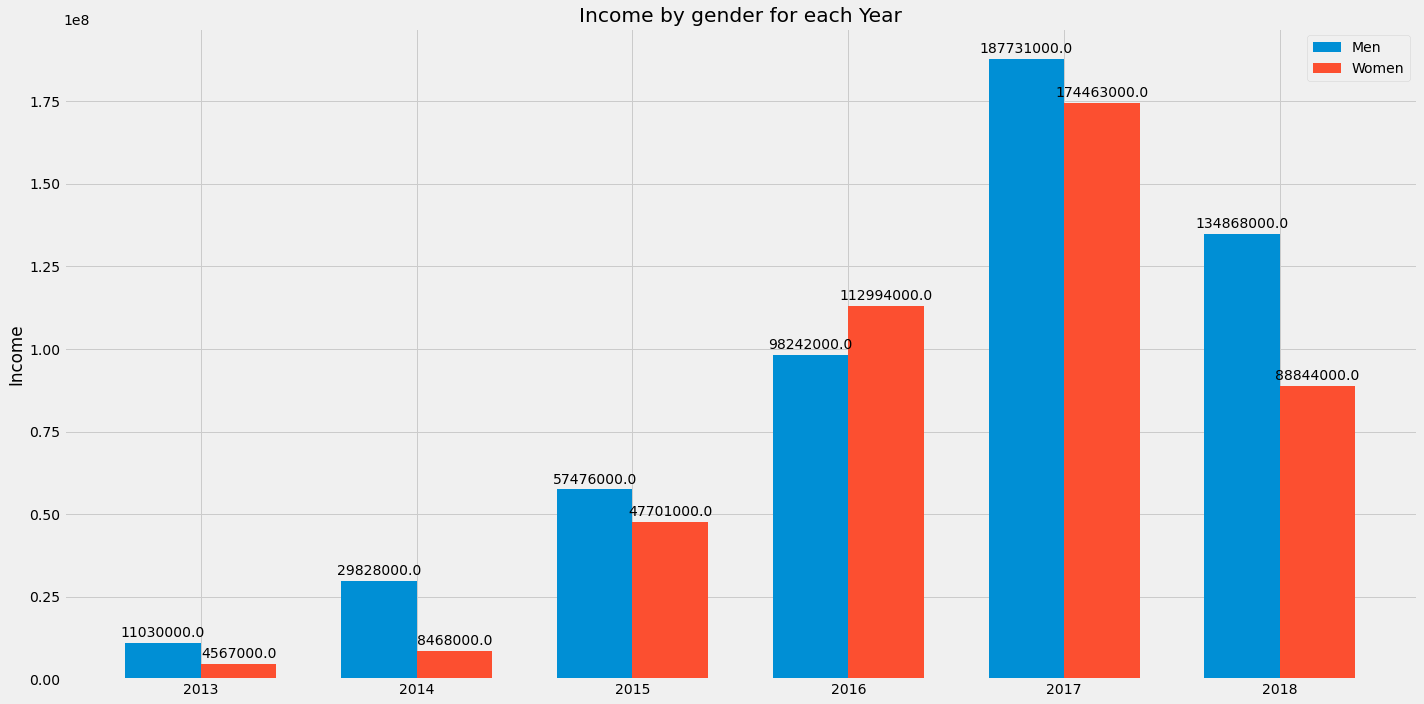

In [88]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
labels = datamembershipstartyearM.membershipstartyear
men = datamembershipstartyearM.income
women = datamembershipstartyearF.income

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x - width/2, men, width, label='Men')
rects2 = ax.bar(x + width/2, women, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Income')
ax.set_title('Income by gender for each Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

As shown in the graph the highest income recorded in 2017.

In [ ]:
### Income for Age Range

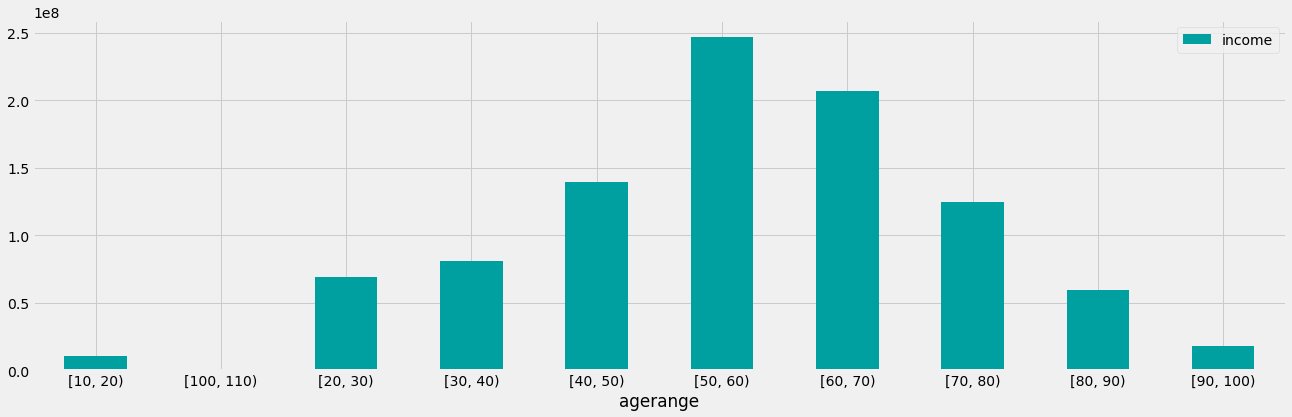

In [89]:
min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

profile['agerange'] =\
    pd.cut(profile['age'],
            (range(min_age_limit,max_age_limit + 10, 10)),
            right=False)
profile['agerange'] = profile['agerange'].astype('str')
dataAgeRange = profile.groupby('agerange')['income'].sum().reset_index()
ax = dataAgeRange.plot.bar(x='agerange', y='income', rot=0, figsize=(20,6),color = '#00A0A0')

## 6. Preparing the Data

In [95]:
dataset_1 = pd.merge(profile, transaction, on='customerid')
dataset_2 = pd.merge(dataset_1, offer_data, on='customerid')
dataset_3 = pd.merge(dataset_2, portfolio, on='offerid')
dataset_3.head()

,gender,age,customerid,became_member_on,income,membershipstartyear,membershipstartMonth,agerange,"[10, 20)","[100, 110)",...,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,...,5,5,7,1,0,0,1,1,0,1
1,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,...,5,5,7,1,0,0,1,1,0,1
2,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,...,5,5,7,1,0,0,1,1,0,1
3,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,...,5,5,7,1,0,0,1,1,0,1
4,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,"[50, 60)",0,0,...,5,5,7,1,0,0,1,1,0,1


In [96]:
dataset_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308957 entries, 0 to 1308956
Data columns (total 34 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   gender                1308957 non-null  int64         
 1   age                   1308957 non-null  int64         
 2   customerid            1308957 non-null  object        
 3   became_member_on      1308957 non-null  datetime64[ns]
 4   income                1308957 non-null  float64       
 5   membershipstartyear   1308957 non-null  int64         
 6   membershipstartMonth  1308957 non-null  int64         
 7   agerange              1308957 non-null  object        
 8   [10, 20)              1308957 non-null  uint8         
 9   [100, 110)            1308957 non-null  uint8         
 10  [20, 30)              1308957 non-null  uint8         
 11  [30, 40)              1308957 non-null  uint8         
 12  [40, 50)              1308957 non-null  ui

## 1.Transforming Skewed Continuous Features

In [103]:
Y = dataset_3['income']
X = dataset_3.drop(['income'], axis = 1)

In [104]:
X = X.drop(['became_member_on','customerid','agerange', 'offerid',
                          '[10, 20)','[100, 110)',
                          '[20, 30)','[30, 40)',
                          '[40, 50)','[50, 60)',
                          '[60, 70)','[70, 80)',
                          '[80, 90)','[90, 100)'], axis = 1)

### Feature scaling
Feature scaling is a method used to normalize the range of independent variables or features of data.

In [105]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'membershipstartyear',
             'membershipstartMonth','amount',
             'timedays','difficulty',
             'duration','reward']
X[numerical] = scaler.fit_transform(X[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,gender,age,membershipstartyear,membershipstartMonth,amount,timedays,completed,received,viewed,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
0,1,0.445783,0.8,0.545455,0.020203,0.571429,0,1,0,0.5,0.25,0.571429,1,0,0,1,1,0,1


In [107]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)


In [112]:
X_test.shape

(261792, 19)